In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the paths to the dataset
train_dir = "/kaggle/input/sports-image-classification/dataset/train"
test_dir = "/kaggle/input/sports-image-classification/dataset/test"
train_csv_path = "/kaggle/input/sports-image-classification/dataset/train.csv"
test_csv_path = "/kaggle/input/sports-image-classification/dataset/test.csv"

# Load the train.csv which contains labels for the training set
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [3]:
# Print the column names to ensure correct structure
print("train_df columns:", train_df.columns)
print("test_df columns:", test_df.columns)

# Adjust the index or column names based on actual structure


train_df columns: Index(['image_ID', 'label'], dtype='object')
test_df columns: Index(['image_ID'], dtype='object')


# Visualize/Summarize the data

In [21]:
# (a) Number of images in the training and testing set and number of classes in the target variable

num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
num_classes = train_df['label'].nunique()

print(f"Number of images in the training set: {num_train_images}")
print(f"Number of images in the testing set: {num_test_images}")
print(f"Number of classes: {num_classes}")

Number of images in the training set: 8227
Number of images in the testing set: 2056
Number of classes: 7


Number of images per class:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


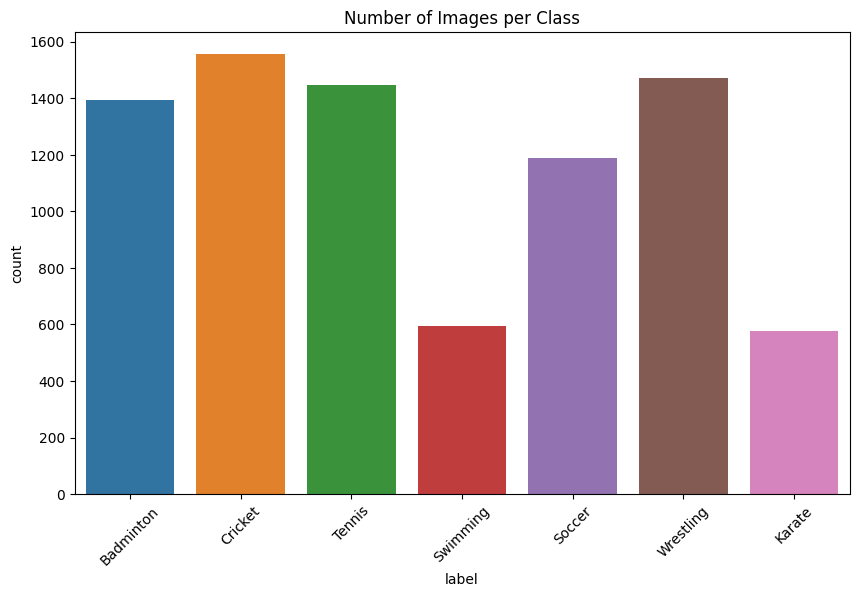

In [22]:
# (b) Number of images per class
images_per_class = train_df['label'].value_counts()
print(f"Number of images per class:\n{images_per_class}")

# Plot the distribution of images per class
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

In [23]:
# (c) Number of pixels (Height and Width) in the first 2 images of each class
class_images = {}
for label in train_df['label'].unique():
    class_images[label] = train_df[train_df['label'] == label]['image_ID'].values[:2]  # Use 'image_ID' column

for label, images in class_images.items():
    for img_file in images:
        img_path = os.path.join(train_dir, img_file)
        img = cv2.imread(img_path)
        height, width = img.shape[:2]
        print(f"Class: {label}, Image: {img_file}, Height: {height}, Width: {width}")

Class: Badminton, Image: 7c225f7b61.jpg, Height: 285, Width: 380
Class: Badminton, Image: b31.jpg, Height: 172, Width: 268
Class: Cricket, Image: cfd2c28c74.jpg, Height: 900, Width: 1200
Class: Cricket, Image: cdddf0986c.jpg, Height: 1152, Width: 2048
Class: Tennis, Image: e06a27208d.jpg, Height: 168, Width: 299
Class: Tennis, Image: 70932bc9b7.jpg, Height: 168, Width: 300
Class: Swimming, Image: da4d3e218c.jpg, Height: 194, Width: 259
Class: Swimming, Image: 84f0137b10.jpg, Height: 720, Width: 1280
Class: Soccer, Image: 9ec9dbc59a.jpg, Height: 168, Width: 300
Class: Soccer, Image: 17bf27328c.jpg, Height: 188, Width: 268
Class: Wrestling, Image: 772648a478.jpg, Height: 788, Width: 1400
Class: Wrestling, Image: 89ce36a3ec.jpg, Height: 576, Width: 1024
Class: Karate, Image: c7657216ce.jpg, Height: 168, Width: 300
Class: Karate, Image: 8116da71f7.jpg, Height: 183, Width: 275


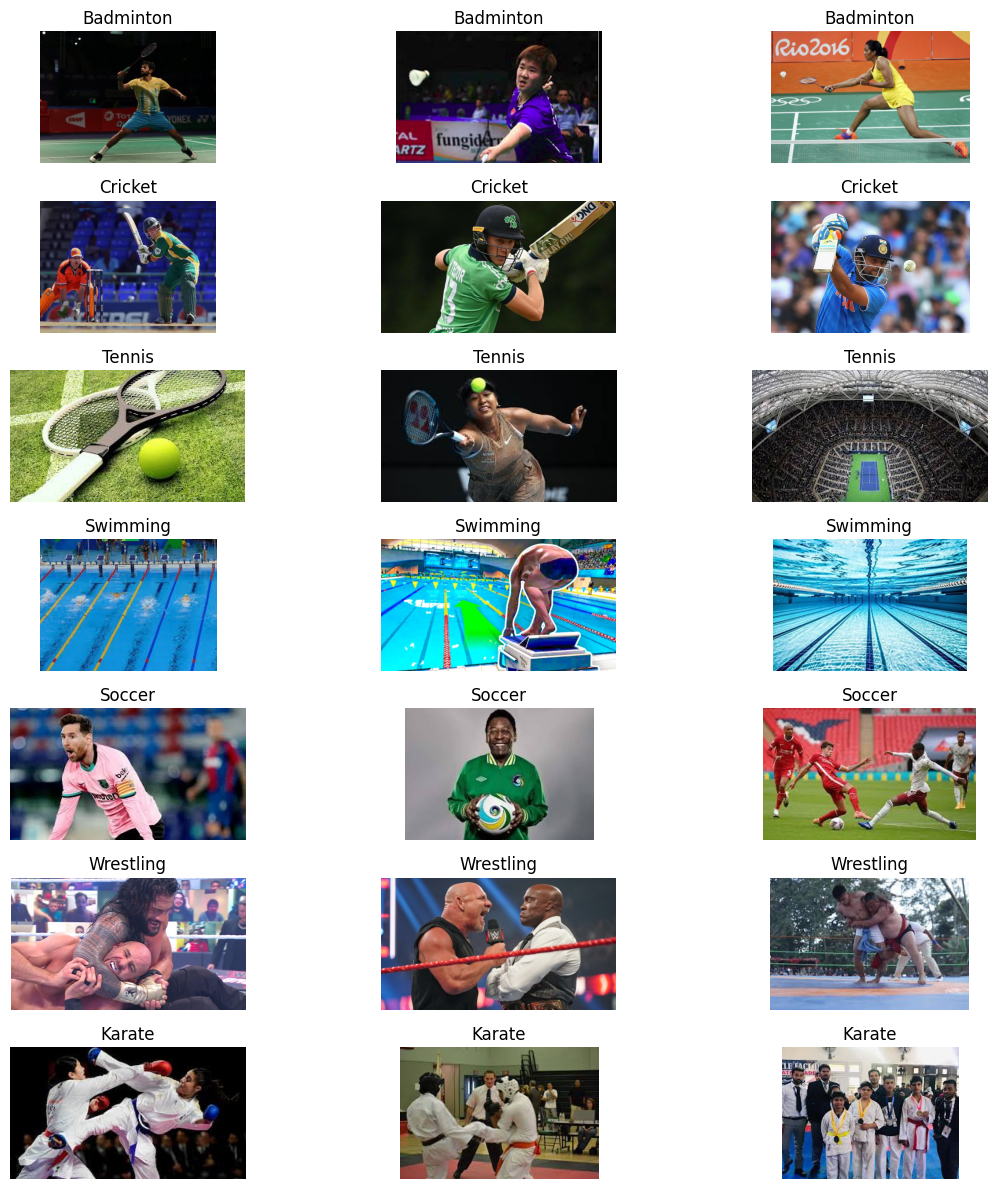

In [24]:
# (d) Display at least 3 images of each class
plt.figure(figsize=(12, 12))
for i, label in enumerate(train_df['label'].unique()):
    images = train_df[train_df['label'] == label]['image_ID'].values[:3]  # Use 'image_ID' column
    for j, img_file in enumerate(images):
        img_path = os.path.join(train_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(train_df['label'].unique()), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.tight_layout()
plt.show()

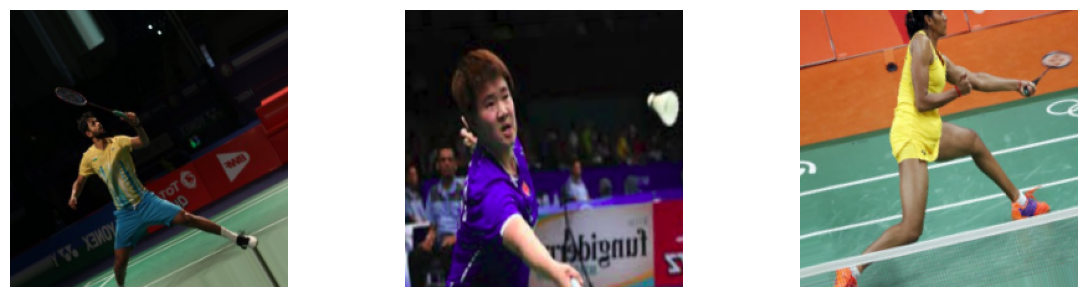

In [25]:
# (e) Apply data augmentation and plot a sample of processed images
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)

# Select 3 images of a class for data augmentation demonstration
sample_images = train_df[train_df['label'] == train_df['label'].unique()[0]]['image_ID'].values[:3]  # Use 'image_ID' column

plt.figure(figsize=(12, 6))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(train_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize if necessary

    img = img.reshape((1,) + img.shape)  # Reshape to feed into the ImageDataGenerator
    aug_iter = datagen.flow(img)
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(aug_iter[0][0].astype('uint8'))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Train a neural network

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Define the paths to the dataset
train_dir = "/kaggle/input/sports-image-classification/dataset/train"
test_dir = "/kaggle/input/sports-image-classification/dataset/test"
train_csv_path = "/kaggle/input/sports-image-classification/dataset/train.csv"
test_csv_path = "/kaggle/input/sports-image-classification/dataset/test.csv"

# Load the train.csv which contains labels for the training set
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path) 

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        p_t = torch.exp(-cross_entropy_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * cross_entropy_loss
        return focal_loss.mean()
    
# Get unique class labels from the training DataFrame
unique_labels = train_df.iloc[:, 1].unique()
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Invert the mapping (optional, for later use if needed)
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Updated SportsImageDataset class to handle datasets without labels
class SportsImageDataset(Dataset):
    def __init__(self, df, img_dir, label_to_index, transform=None, is_test=False):
        """
        Args:
            df (DataFrame): DataFrame containing image IDs and labels (if available).
            img_dir (str): Directory with all the images.
            label_to_index (dict): Mapping from label names to label indices.
            transform (callable, optional): Optional transform to be applied on a sample.
            is_test (bool): Flag indicating if this is a test dataset (no labels).
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_index = label_to_index
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])  # 'image_ID' assumed to be in the first column
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

        # Check if the dataset is test set and handle labels accordingly
        if not self.is_test:
            label = self.df.iloc[idx, 1]  # Use the second column for labels in the training set
            label = self.label_to_index[label]  # Convert string label to an integer index
        else:
            label = -1  # Placeholder label for test set

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label).long()  # Convert label to tensor and ensure it's a long tensor

        return image, label

# Data transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Initialize train and test datasets
train_dataset = SportsImageDataset(df=train_df, img_dir=train_dir, label_to_index=label_to_index, transform=train_transforms)
test_dataset = SportsImageDataset(df=test_df, img_dir=test_dir, label_to_index=label_to_index, transform=test_transforms, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN model definition
class CustomCNN(nn.Module):
    def __init__(self, activation_fn):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(unique_labels))  # Number of classes from the dataset
        self.dropout = nn.Dropout(0.5)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = nn.MaxPool2d(2)(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        return x

# Activation function mapping
activation_fn_map = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(),
    'Tanh': nn.Tanh()
}

# Additional Loss Functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (pred.size(1) - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

class HingeLoss(nn.Module):
    def forward(self, pred, target):
        target = 2 * target - 1  # Convert to -1 or 1
        return torch.mean(torch.clamp(1 - pred * target, min=0))

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        smooth = 1.0
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Loss function mapping
loss_fn_map = {
    'CrossEntropy': nn.CrossEntropyLoss(),
    'FocalLoss': FocalLoss(),  # Focal Loss defined earlier
    'LabelSmoothingCrossEntropy': LabelSmoothingCrossEntropy(smoothing=0.1),  # Smoothed Cross-Entropy
    'HingeLoss': HingeLoss(),  # Hinge Loss
    'KLDivLoss': nn.KLDivLoss(reduction='batchmean'),  # KL Divergence Loss
    'DiceLoss': DiceLoss(),  # Dice Loss
    'CosineEmbeddingLoss': nn.CosineEmbeddingLoss()  # Cosine Embedding Loss
}

# Optimizer function
def get_optimizer(optimizer_name, model, lr=0.001):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=lr)
    return None

# Modified train and evaluate function with validation
# Modified train and evaluate function with validation
def train_and_evaluate(combo, train_loader, val_loader):
    model = CustomCNN(activation_fn_map[combo['activation']]).to(device)
    optimizer = get_optimizer(combo['optimizer'], model)
    loss_fn = loss_fn_map[combo['loss_fn']]
    
    # Calculate and print the number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(combo['epochs']):
        model.train()
        running_loss = 0.0
        true_labels, pred_labels = [], []
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_f1 = f1_score(true_labels, pred_labels, average='macro')
        train_f1_scores.append(train_f1)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_true_labels, val_pred_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(preds.cpu().numpy())
        
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_f1 = f1_score(val_true_labels, val_pred_labels, average='macro')
        val_f1_scores.append(val_f1)

        print(f"Epoch [{epoch+1}/{combo['epochs']}], "
              f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")
    
    return train_losses, train_f1_scores, val_losses, val_f1_scores
# Visualization function with validation data
def visualize_results(combo, train_losses, train_f1_scores, val_losses, val_f1_scores):
    epochs = range(1, combo['epochs'] + 1)
    plt.figure(figsize=(14, 6))
    
    # Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss", linestyle='--')
    plt.title(f"Loss vs Epochs ({combo['activation']}, {combo['optimizer']}, {combo['loss_fn']})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # F1 Score vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, label="Training F1 Score", color="orange")
    plt.plot(epochs, val_f1_scores, label="Validation F1 Score", color="red", linestyle='--')
    plt.title(f"F1 Score vs Epochs ({combo['activation']}, {combo['optimizer']}, {combo['loss_fn']})")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    
    plt.show()

    
# Function to display predictions from the test dataset with a placeholder check
def display_test_predictions(model, test_loader, index_to_label, num_images=5):
    model.eval()
    images_displayed = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(inputs)):
                if images_displayed >= num_images:
                    return
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                pred = index_to_label[preds[i].item()]

                # Check if label is -1 (test dataset) and handle accordingly
                if labels[i].item() == -1:
                    true_label = "N/A"  # No true label available
                else:
                    true_label = index_to_label[labels[i].item()]
                
                plt.imshow(image)
                plt.title(f"True: {true_label}, Predicted: {pred}")
                plt.axis("off")
                plt.show()
                
                images_displayed += 1


Epoch [1/10], Loss: 1.3991, F1: 0.4434
Epoch [2/10], Loss: 1.1235, F1: 0.5839
Epoch [3/10], Loss: 1.0167, F1: 0.6272
Epoch [4/10], Loss: 0.9323, F1: 0.6577
Epoch [5/10], Loss: 0.8797, F1: 0.6822
Epoch [6/10], Loss: 0.8106, F1: 0.7085
Epoch [7/10], Loss: 0.7673, F1: 0.7232
Epoch [8/10], Loss: 0.7331, F1: 0.7345
Epoch [9/10], Loss: 0.6911, F1: 0.7482
Epoch [10/10], Loss: 0.6427, F1: 0.7631


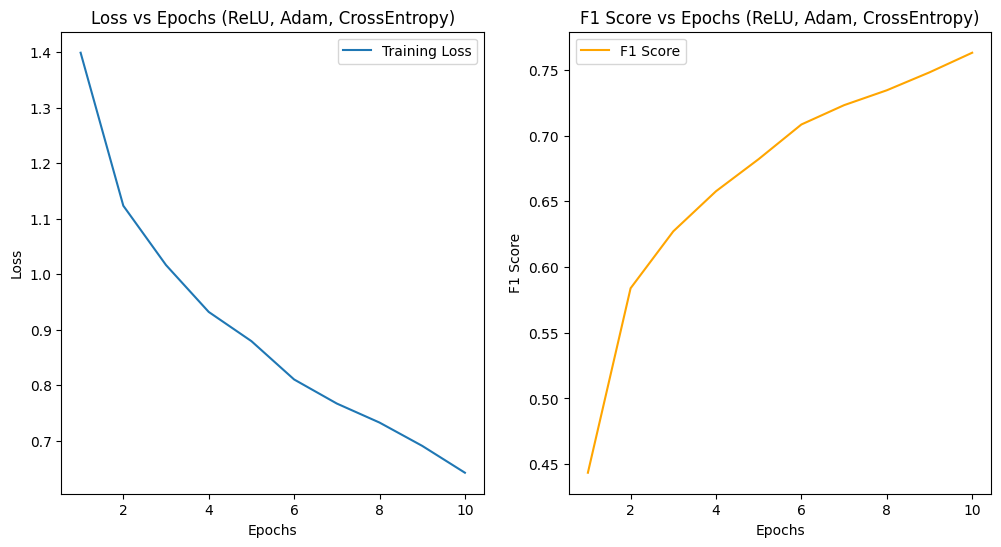

In [8]:
combo_1 = {
    'epochs': 10, 
    'batch_size': 32, 
    'activation': 'ReLU', 
    'optimizer': 'Adam', 
    'loss_fn': 'CrossEntropy', 
    'regularizations': ['Dropout', 'L2', 'DataAugmentation']
}

losses_1, f1_scores_1 = train_and_evaluate(combo_1, train_loader)
visualize_results(combo_1, losses_1, f1_scores_1)


Epoch [1/15], Loss: 0.3475, F1: 0.1107
Epoch [2/15], Loss: 0.3344, F1: 0.1657
Epoch [3/15], Loss: 0.3176, F1: 0.2300
Epoch [4/15], Loss: 0.2967, F1: 0.2867
Epoch [5/15], Loss: 0.2802, F1: 0.3159
Epoch [6/15], Loss: 0.2699, F1: 0.3344
Epoch [7/15], Loss: 0.2571, F1: 0.3522
Epoch [8/15], Loss: 0.2473, F1: 0.3841
Epoch [9/15], Loss: 0.2407, F1: 0.4030
Epoch [10/15], Loss: 0.2332, F1: 0.4173
Epoch [11/15], Loss: 0.2263, F1: 0.4449
Epoch [12/15], Loss: 0.2194, F1: 0.4619
Epoch [13/15], Loss: 0.2121, F1: 0.4857
Epoch [14/15], Loss: 0.2080, F1: 0.4942
Epoch [15/15], Loss: 0.2038, F1: 0.5088


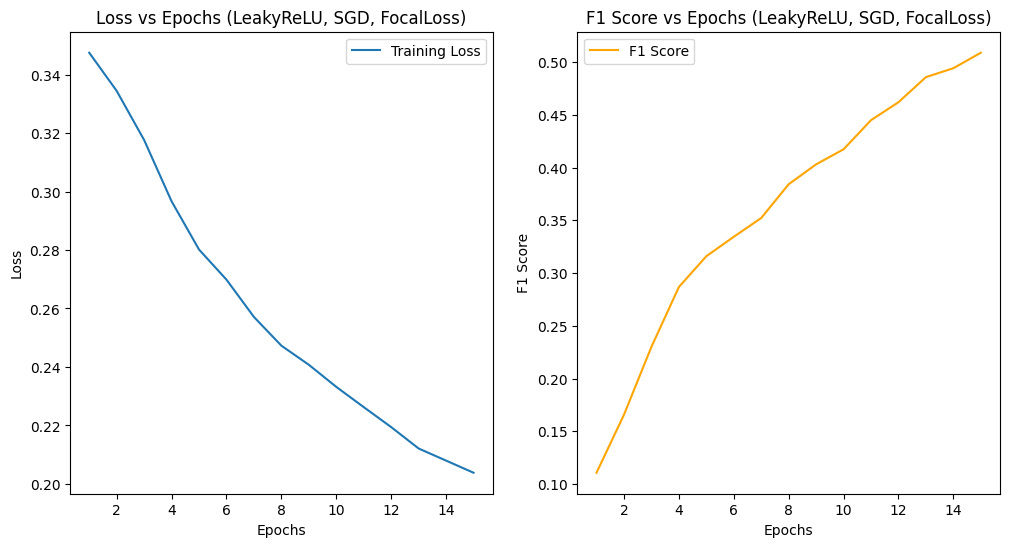

In [9]:
combo_2 = {
    'epochs': 15, 
    'batch_size': 64, 
    'activation': 'LeakyReLU', 
    'optimizer': 'SGD', 
    'loss_fn': 'FocalLoss', 
    'regularizations': ['Dropout', 'L2', 'DataAugmentation']
}

losses_2, f1_scores_2 = train_and_evaluate(combo_2, train_loader)
visualize_results(combo_2, losses_2, f1_scores_2)


Epoch [1/20], Loss: 1.7067, F1: 0.3274
Epoch [2/20], Loss: 1.5522, F1: 0.4477
Epoch [3/20], Loss: 1.5339, F1: 0.4572
Epoch [4/20], Loss: 1.5335, F1: 0.4591
Epoch [5/20], Loss: 1.5232, F1: 0.4618
Epoch [6/20], Loss: 1.5168, F1: 0.4719
Epoch [7/20], Loss: 1.5205, F1: 0.4654
Epoch [8/20], Loss: 1.5257, F1: 0.4550
Epoch [9/20], Loss: 1.4843, F1: 0.4943
Epoch [10/20], Loss: 1.4818, F1: 0.4836
Epoch [11/20], Loss: 1.4796, F1: 0.4922
Epoch [12/20], Loss: 1.4746, F1: 0.4925
Epoch [13/20], Loss: 1.4780, F1: 0.4949
Epoch [14/20], Loss: 1.4755, F1: 0.4927
Epoch [15/20], Loss: 1.4834, F1: 0.4932
Epoch [16/20], Loss: 1.4694, F1: 0.4938
Epoch [17/20], Loss: 1.4458, F1: 0.5149
Epoch [18/20], Loss: 1.4534, F1: 0.4989
Epoch [19/20], Loss: 1.4432, F1: 0.5031
Epoch [20/20], Loss: 1.4712, F1: 0.4979


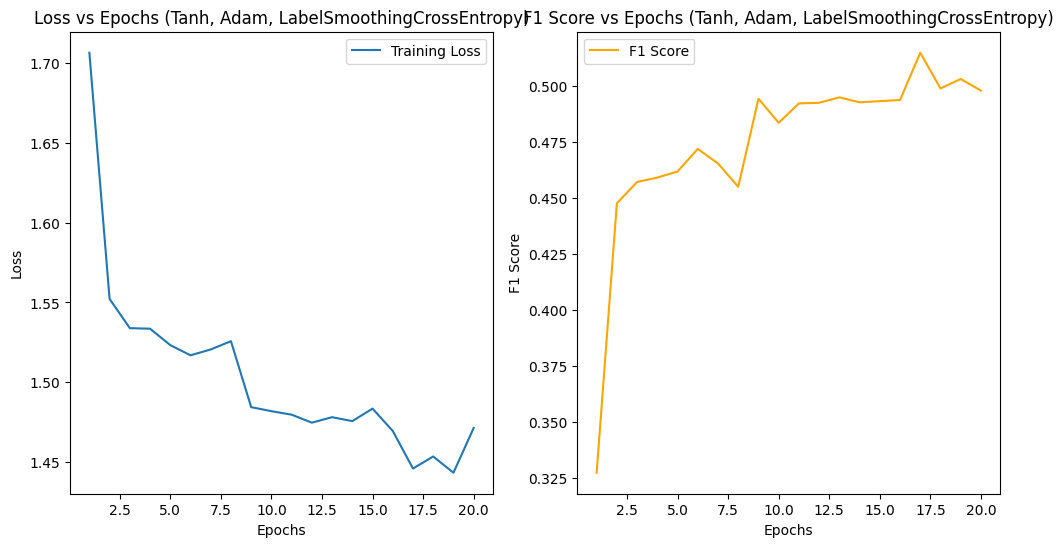

In [10]:
combo_3 = {
    'epochs': 20, 
    'batch_size': 32, 
    'activation': 'Tanh', 
    'optimizer': 'Adam', 
    'loss_fn': 'LabelSmoothingCrossEntropy', 
    'regularizations': ['Dropout', 'L2', 'DataAugmentation']
}

losses_3, f1_scores_3 = train_and_evaluate(combo_3, train_loader)
visualize_results(combo_3, losses_3, f1_scores_3)


Epoch [1/20], Loss: 1.5738, F1: 0.3316
Epoch [2/20], Loss: 1.2299, F1: 0.5248
Epoch [3/20], Loss: 1.0910, F1: 0.5893
Epoch [4/20], Loss: 1.0137, F1: 0.6229
Epoch [5/20], Loss: 0.9657, F1: 0.6416
Epoch [6/20], Loss: 0.9311, F1: 0.6639
Epoch [7/20], Loss: 0.8667, F1: 0.6884
Epoch [8/20], Loss: 0.8531, F1: 0.6895
Epoch [9/20], Loss: 0.8095, F1: 0.7135
Epoch [10/20], Loss: 0.7841, F1: 0.7152
Epoch [11/20], Loss: 0.7589, F1: 0.7215
Epoch [12/20], Loss: 0.7110, F1: 0.7401
Epoch [13/20], Loss: 0.6885, F1: 0.7425
Epoch [14/20], Loss: 0.6643, F1: 0.7542
Epoch [15/20], Loss: 0.6295, F1: 0.7625
Epoch [16/20], Loss: 0.6068, F1: 0.7745
Epoch [17/20], Loss: 0.5986, F1: 0.7774
Epoch [18/20], Loss: 0.5658, F1: 0.7841
Epoch [19/20], Loss: 0.5558, F1: 0.7863
Epoch [20/20], Loss: 0.5445, F1: 0.7965


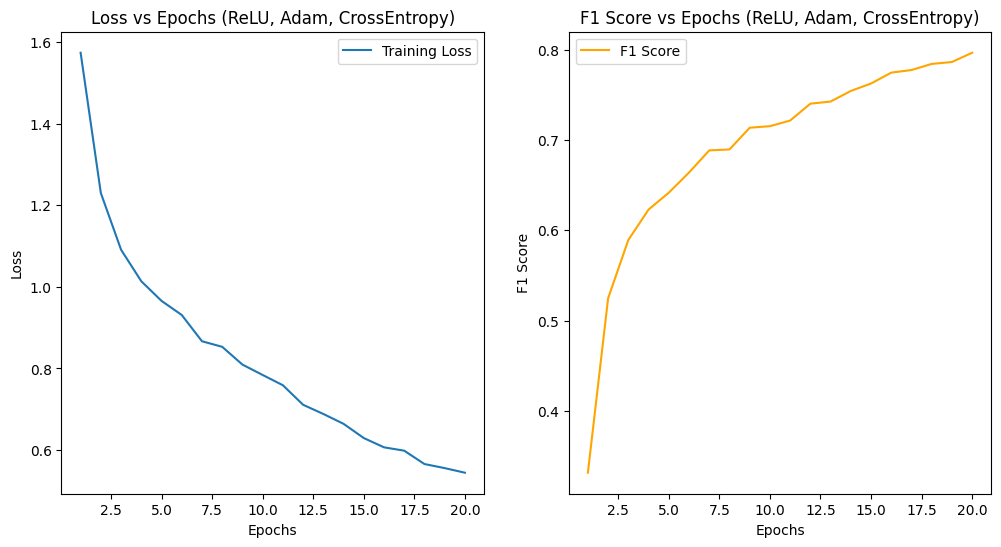

In [11]:
combo_4 = {
    'epochs': 20, 
    'batch_size': 32, 
    'activation': 'ReLU', 
    'optimizer': 'Adam', 
    'loss_fn': 'CrossEntropy', 
    'regularizations': ['Dropout', 'L2', 'DataAugmentation']
}

losses_1, f1_scores_1 = train_and_evaluate(combo_1, train_loader)
visualize_results(combo_1, losses_1, f1_scores_1)


Epoch [1/20], Loss: 1.4505, F1: 0.4100
Epoch [2/20], Loss: 1.1747, F1: 0.5560
Epoch [3/20], Loss: 1.0301, F1: 0.6181
Epoch [4/20], Loss: 0.9740, F1: 0.6420
Epoch [5/20], Loss: 0.9154, F1: 0.6628
Epoch [6/20], Loss: 0.8585, F1: 0.6929
Epoch [7/20], Loss: 0.7954, F1: 0.7167
Epoch [8/20], Loss: 0.7791, F1: 0.7248
Epoch [9/20], Loss: 0.7423, F1: 0.7295
Epoch [10/20], Loss: 0.6812, F1: 0.7558
Epoch [11/20], Loss: 0.6475, F1: 0.7722
Epoch [12/20], Loss: 0.6268, F1: 0.7701
Epoch [13/20], Loss: 0.5976, F1: 0.7844
Epoch [14/20], Loss: 0.5713, F1: 0.7913
Epoch [15/20], Loss: 0.5432, F1: 0.8024
Epoch [16/20], Loss: 0.5233, F1: 0.8110
Epoch [17/20], Loss: 0.5156, F1: 0.8140
Epoch [18/20], Loss: 0.4848, F1: 0.8254
Epoch [19/20], Loss: 0.4615, F1: 0.8283
Epoch [20/20], Loss: 0.4370, F1: 0.8420


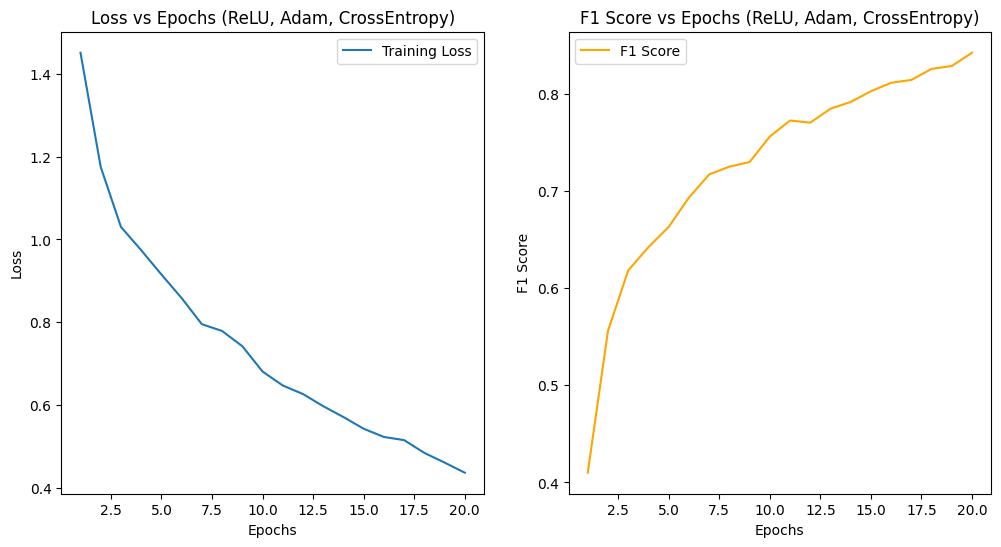

In [12]:
combo_5 = {
    'epochs': 30, 
    'batch_size': 32, 
    'activation': 'ReLU', 
    'optimizer': 'Adam', 
    'loss_fn': 'CrossEntropy', 
    'regularizations': ['Dropout', 'L2', 'DataAugmentation']
}

losses_1, f1_scores_1 = train_and_evaluate(combo_1, train_loader)
visualize_results(combo_1, losses_1, f1_scores_1)


# Out of all The below combo have given me the best accuracy with less time. 

Epoch [1/25], Loss: 1.6156, F1: 0.3413
Epoch [2/25], Loss: 1.2583, F1: 0.5293
Epoch [3/25], Loss: 1.1483, F1: 0.5772
Epoch [4/25], Loss: 1.0591, F1: 0.6150
Epoch [5/25], Loss: 0.9926, F1: 0.6364
Epoch [6/25], Loss: 0.9422, F1: 0.6628
Epoch [7/25], Loss: 0.8752, F1: 0.6874
Epoch [8/25], Loss: 0.8491, F1: 0.6946
Epoch [9/25], Loss: 0.7762, F1: 0.7172
Epoch [10/25], Loss: 0.7633, F1: 0.7237
Epoch [11/25], Loss: 0.6772, F1: 0.7579
Epoch [12/25], Loss: 0.6539, F1: 0.7646
Epoch [13/25], Loss: 0.6615, F1: 0.7588
Epoch [14/25], Loss: 0.6280, F1: 0.7715
Epoch [15/25], Loss: 0.5633, F1: 0.7929
Epoch [16/25], Loss: 0.5510, F1: 0.8051
Epoch [17/25], Loss: 0.5536, F1: 0.8021
Epoch [18/25], Loss: 0.5546, F1: 0.7995
Epoch [19/25], Loss: 0.5188, F1: 0.8155
Epoch [20/25], Loss: 0.4410, F1: 0.8413
Epoch [21/25], Loss: 0.9260, F1: 0.7064
Epoch [22/25], Loss: 0.5377, F1: 0.8051
Epoch [23/25], Loss: 0.4789, F1: 0.8239
Epoch [24/25], Loss: 0.4052, F1: 0.8540
Epoch [25/25], Loss: 0.3998, F1: 0.8579


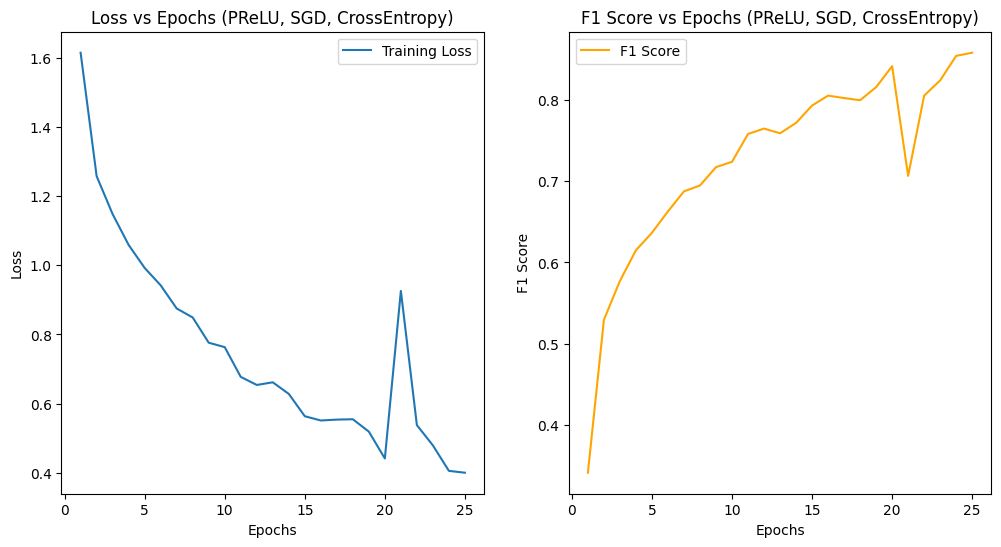

In [18]:
combo_6 = {
    'epochs': 25, 
    'batch_size': 32, 
    'activation': 'PReLU',  # Parametric ReLU
    'optimizer': 'SGD', 
    'loss_fn': 'CrossEntropy', 
    'regularizations': ['Dropout', 'L2'],
    'learning_rate': 0.01,  # Higher learning rate with SGD
    'momentum': 0.9  # SGD momentum
}

# Define PReLU activation function directly in the model
class CustomCNN_PReLU(nn.Module):
    def __init__(self):
        super(CustomCNN_PReLU, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(unique_labels))
        self.dropout = nn.Dropout(0.5)
        self.prelu = nn.PReLU()  # Use PReLU as activation

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv2(x)
        x = self.prelu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.prelu(x)
        x = self.fc2(x)
        return x
    
def train_and_evaluate_prelu(combo, train_loader):
    # Check if the activation function is PReLU
    if combo['activation'] == 'PReLU':
        model = CustomCNN_PReLU().to(device)  # Use the custom PReLU model
    else:
        model = CustomCNN(activation_fn_map[combo['activation']]).to(device)  # Use the default activation function
    
    optimizer = get_optimizer(combo['optimizer'], model, lr=combo['learning_rate'])  # Use the get_optimizer function
    loss_fn = loss_fn_map[combo['loss_fn']]  # Get the appropriate loss function
    
    train_losses = []
    f1_scores = []
    
    for epoch in range(combo['epochs']):
        model.train()
        running_loss = 0.0
        true_labels, pred_labels = [], []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        f1 = f1_score(true_labels, pred_labels, average='macro')
        f1_scores.append(f1)
        print(f"Epoch [{epoch+1}/{combo['epochs']}], Loss: {avg_loss:.4f}, F1: {f1:.4f}")
    
    return train_losses, f1_scores


# Use the existing get_optimizer function
model_6 = CustomCNN_PReLU().to(device)
optimizer_6 = get_optimizer(combo_6['optimizer'], model_6, lr=combo_6['learning_rate'])  # No need for a new function
loss_fn = loss_fn_map[combo_6['loss_fn']]  # Get loss function from the mapping

# Train the model using the existing train_and_evaluate function from your main code
losses_6, f1_scores_6 = train_and_evaluate_prelu(combo_6, train_loader)
visualize_results(combo_6, losses_6, f1_scores_6)


Now lets do, 4. H, I, J

In [10]:
combo_6 = {
    'epochs': 25, 
    'batch_size': 32, 
    'activation': 'PReLU',  # Parametric ReLU
    'optimizer': 'SGD', 
    'loss_fn': 'CrossEntropy', 
    'regularizations': ['Dropout', 'L2'],
    'learning_rate': 0.01,  # Higher learning rate with SGD
    'momentum': 0.9  # SGD momentum
}

Number of trainable parameters: 2117576
Epoch [1/25], Train Loss: 1.6200, Train F1: 0.3383, Val Loss: 1.3579, Val F1: 0.4624
Epoch [2/25], Train Loss: 1.2932, Train F1: 0.5169, Val Loss: 1.2553, Val F1: 0.5322
Epoch [3/25], Train Loss: 1.1868, Train F1: 0.5652, Val Loss: 1.0477, Val F1: 0.5900
Epoch [4/25], Train Loss: 1.0931, Train F1: 0.5957, Val Loss: 0.9730, Val F1: 0.6329
Epoch [5/25], Train Loss: 1.0291, Train F1: 0.6240, Val Loss: 0.9188, Val F1: 0.6770
Epoch [6/25], Train Loss: 0.9849, Train F1: 0.6509, Val Loss: 0.8944, Val F1: 0.6751
Epoch [7/25], Train Loss: 0.9038, Train F1: 0.6752, Val Loss: 0.8910, Val F1: 0.6859
Epoch [8/25], Train Loss: 0.8680, Train F1: 0.6922, Val Loss: 0.8386, Val F1: 0.7013
Epoch [9/25], Train Loss: 0.8344, Train F1: 0.6982, Val Loss: 0.8098, Val F1: 0.7094
Epoch [10/25], Train Loss: 0.7872, Train F1: 0.7221, Val Loss: 0.7797, Val F1: 0.7230
Epoch [11/25], Train Loss: 0.7726, Train F1: 0.7234, Val Loss: 0.7632, Val F1: 0.7236
Epoch [12/25], Train Lo

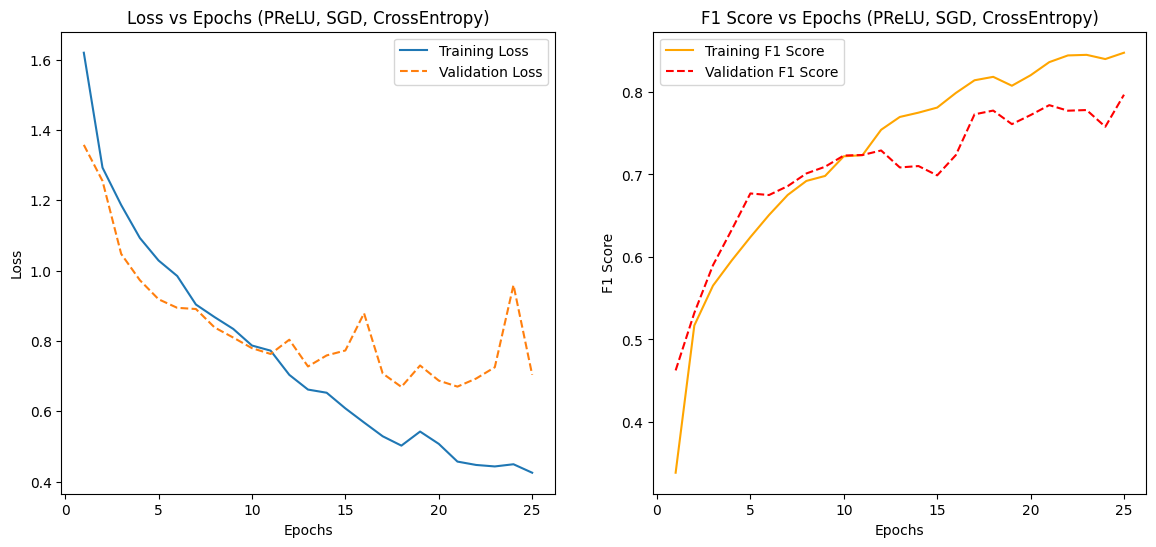

In [13]:
from sklearn.model_selection import train_test_split

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Initialize train, validation, and test datasets
train_dataset = SportsImageDataset(df=train_data, img_dir=train_dir, label_to_index=label_to_index, transform=train_transforms)
val_dataset = SportsImageDataset(df=val_data, img_dir=train_dir, label_to_index=label_to_index, transform=test_transforms)
test_dataset = SportsImageDataset(df=test_df, img_dir=test_dir, label_to_index=label_to_index, transform=test_transforms, is_test=True)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=combo_6['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=combo_6['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=combo_6['batch_size'], shuffle=False)

# Define PReLU activation function directly in the model
class CustomCNN_PReLU(nn.Module):
    def __init__(self):
        super(CustomCNN_PReLU, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(unique_labels))
        self.dropout = nn.Dropout(0.5)
        self.prelu = nn.PReLU()  # Use PReLU as activation

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv2(x)
        x = self.prelu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.prelu(x)
        x = self.fc2(x)
        return x
    
# Updated train_and_evaluate function to return the model as well
def train_and_evaluate_prelu(combo, train_loader, val_loader):
    # Check if the activation function is PReLU
    if combo['activation'] == 'PReLU':
        model = CustomCNN_PReLU().to(device)  # Use the custom PReLU model
    else:
        model = CustomCNN(activation_fn_map[combo['activation']]).to(device)  # Use the default activation function
    
    optimizer = get_optimizer(combo['optimizer'], model, lr=combo['learning_rate'])  # Use the get_optimizer function
    loss_fn = loss_fn_map[combo['loss_fn']]  # Get the appropriate loss function
    
    # Calculate and print the number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")

    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(combo['epochs']):
        model.train()
        running_loss = 0.0
        true_labels, pred_labels = [], []
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_f1 = f1_score(true_labels, pred_labels, average='macro')
        train_f1_scores.append(train_f1)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_true_labels, val_pred_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(preds.cpu().numpy())
        
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_f1 = f1_score(val_true_labels, val_pred_labels, average='macro')
        val_f1_scores.append(val_f1)

        print(f"Epoch [{epoch+1}/{combo['epochs']}], "
              f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")
    
    return model, train_losses, train_f1_scores, val_losses, val_f1_scores

# Train the model and get metrics
model_6, train_losses_6, train_f1_scores_6, val_losses_6, val_f1_scores_6 = train_and_evaluate_prelu(combo_6, train_loader, val_loader)

# Visualize results with both training and validation metrics
visualize_results(combo_6, train_losses_6, train_f1_scores_6, val_losses_6, val_f1_scores_6)



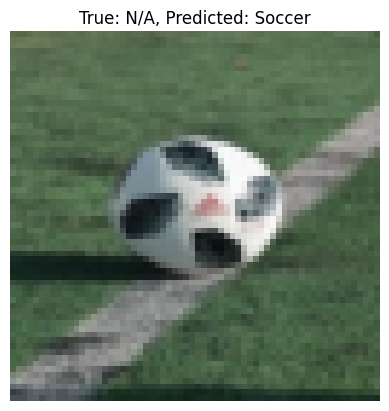

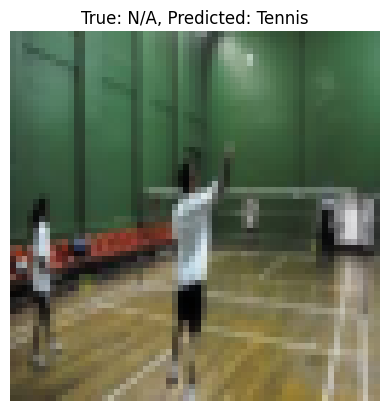

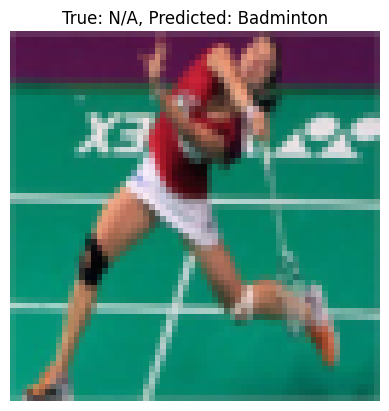

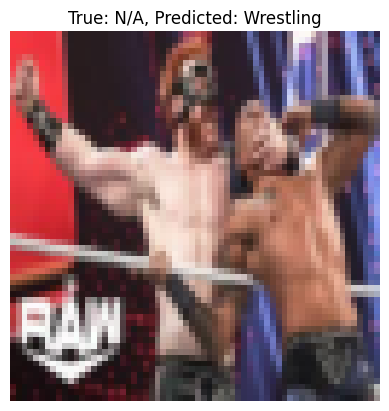

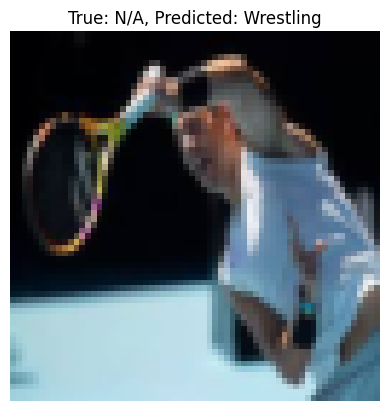

In [14]:
# Display predictions from the test set
display_test_predictions(model_6, test_loader, index_to_label)

In [15]:
# Define a path to save the model weights
model_save_path = "/kaggle/working/model_weights_part2.pth"

# Save the model weights after training
torch.save(model_6.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")


Model weights saved to /kaggle/working/model_weights_part2.pth
